# Mixed Precision Tensorflow

#### reference:
https://youtu.be/FvsKQefDQEs

In [1]:
import tensorflow as tf
import numpy as np
import time
from IPython import display


In [2]:
def build_forward_model(inputs):
    _,_, h, w = inputs.get_shape().as_list()
    top_layer = inputs
    top_layer = tf.layers.conv2d(top_layer, 64, 7, use_bias=False,
                                data_format='channels_first', padding='SAME')
    
    top_layer = tf.contrib.layers.batch_norm(top_layer, data_format='NCHW', fused=True)
    top_layer = tf.layers.max_pooling2d(top_layer, 2, 2, data_format='channels_first')
    top_layer = tf.reshape(top_layer, (-1, 64*(h//2)*(w//2)))
    top_layer = tf.layers.dense(top_layer, 128, activation=tf.nn.relu)
    return top_layer
    

In [3]:
def build_training_model(inputs, labels, nlabel):
    top_layer = build_forward_model(inputs)
    logits    = tf.layers.dense(top_layer, nlabel, activation=None)
    loss      = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
    optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9)
    gradvars  = optimizer.compute_gradients(loss)
    train_op  = optimizer.apply_gradients(gradvars)
    return inputs, labels, loss, train_op
    

In [4]:
nchan, height, width, nlabel = 3, 224, 224, 1000
inputs = tf.compat.v1.placeholder(tf.float32, (None, nchan, height, width))
labels = tf.compat.v1.placeholder(tf.int32, (None,))
inputs, labels, loss, train_op = build_training_model(inputs, labels, nlabel)
batch_size = 128
sess = tf.Session()
inputs_np = np.random.random(size=(batch_size, nchan, height, width)).astype(np.float32)
labels_np = np.random.randint(nlabel, size=(batch_size,)).astype(np.int32)
sess.run(tf.global_variables_initializer())

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.







2023-07-18 13:30:34.233641: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuda.so.1
2023-07-18 13:30:34.278059: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:1082] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-07-18 13:30:34.278183: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1674] Found device 0 with properties: 
name: NVIDIA GeForce RTX 3090 major: 8 minor: 6 memoryClockRate(GHz): 1.74
pciBusID: 0000:0a:00.0
2023-07-18 13:30:34.278200: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudart.so.12
2023-07-18 13:30:34.291871: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-07-18 13:30:34.292998: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcuf

# FP32

In [8]:
st = time.time()
for step in range(20):
    loss_np, _ = sess.run([loss, train_op],
                         {inputs: inputs_np,
                         labels: labels_np}) 
    print("loss=", loss_np)

ed = time.time()
print(f'time: {np.round((ed-st),2)} sec')

# time: 25.79 sec, 22.27 GPU, loss=6.83

2023-07-18 13:27:50.713648: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-07-18 13:27:50.734297: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudnn.so.8


loss= 7.0455894
loss= 11.387368
loss= 72.14704
loss= 78.80615
loss= 104.85711
loss= 6.9012485
loss= 7.0356865
loss= 6.858678
loss= 6.894339
loss= 7.203009
loss= 7.0914574
loss= 6.8649297
loss= 6.843207
loss= 6.7152987
loss= 7.262314
loss= 6.8321147
loss= 6.8654423
loss= 6.8279443
loss= 6.8313212
loss= 6.8317223
time: 25.79 sec


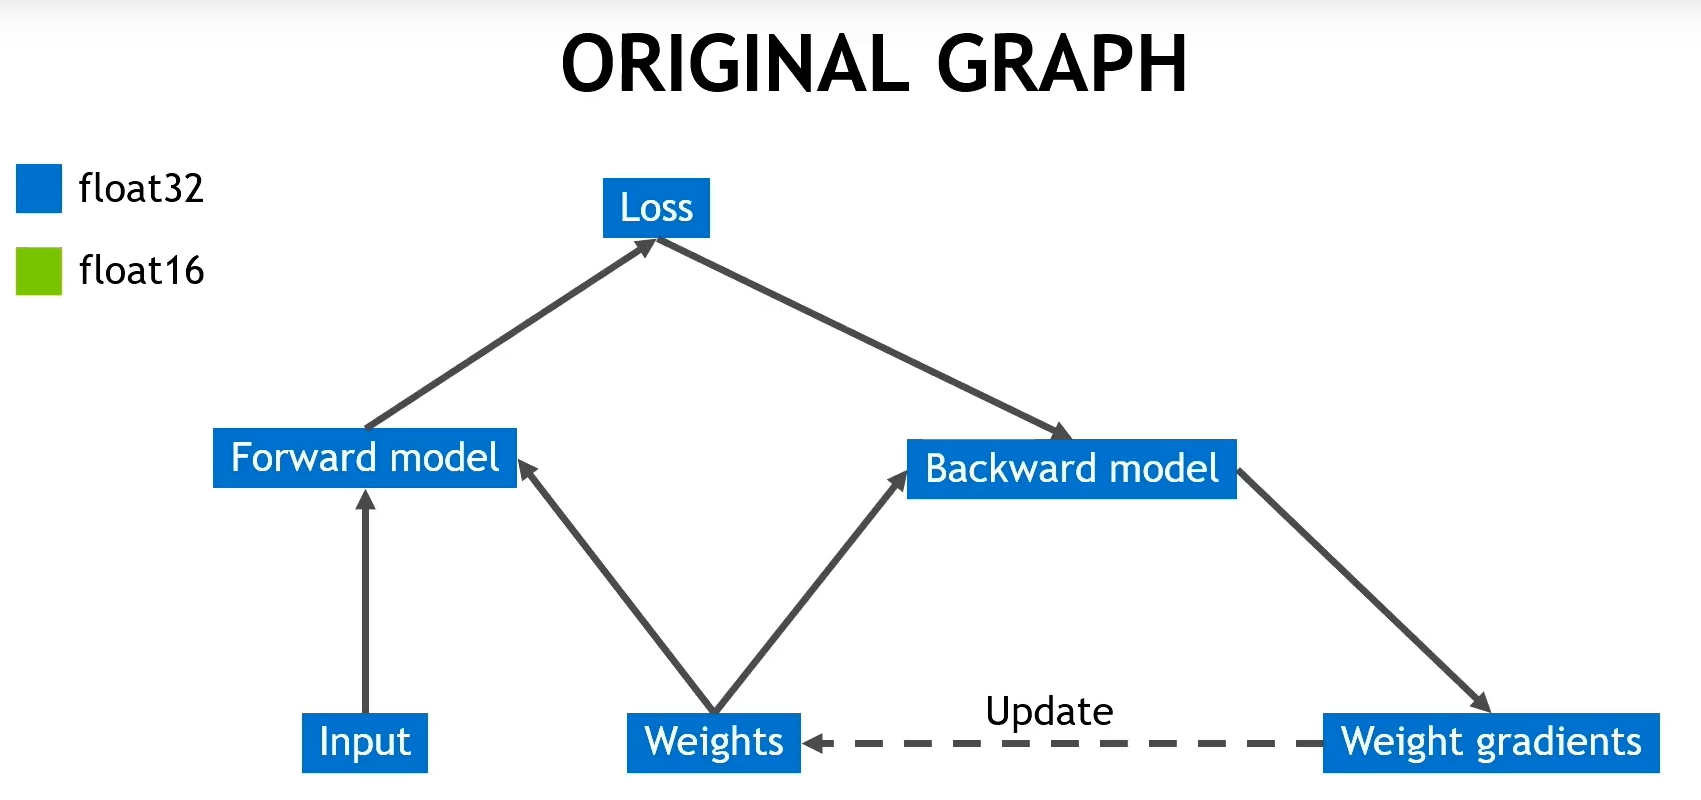

In [2]:
display.Image("png/tf1.png", retina=True)

# FP16

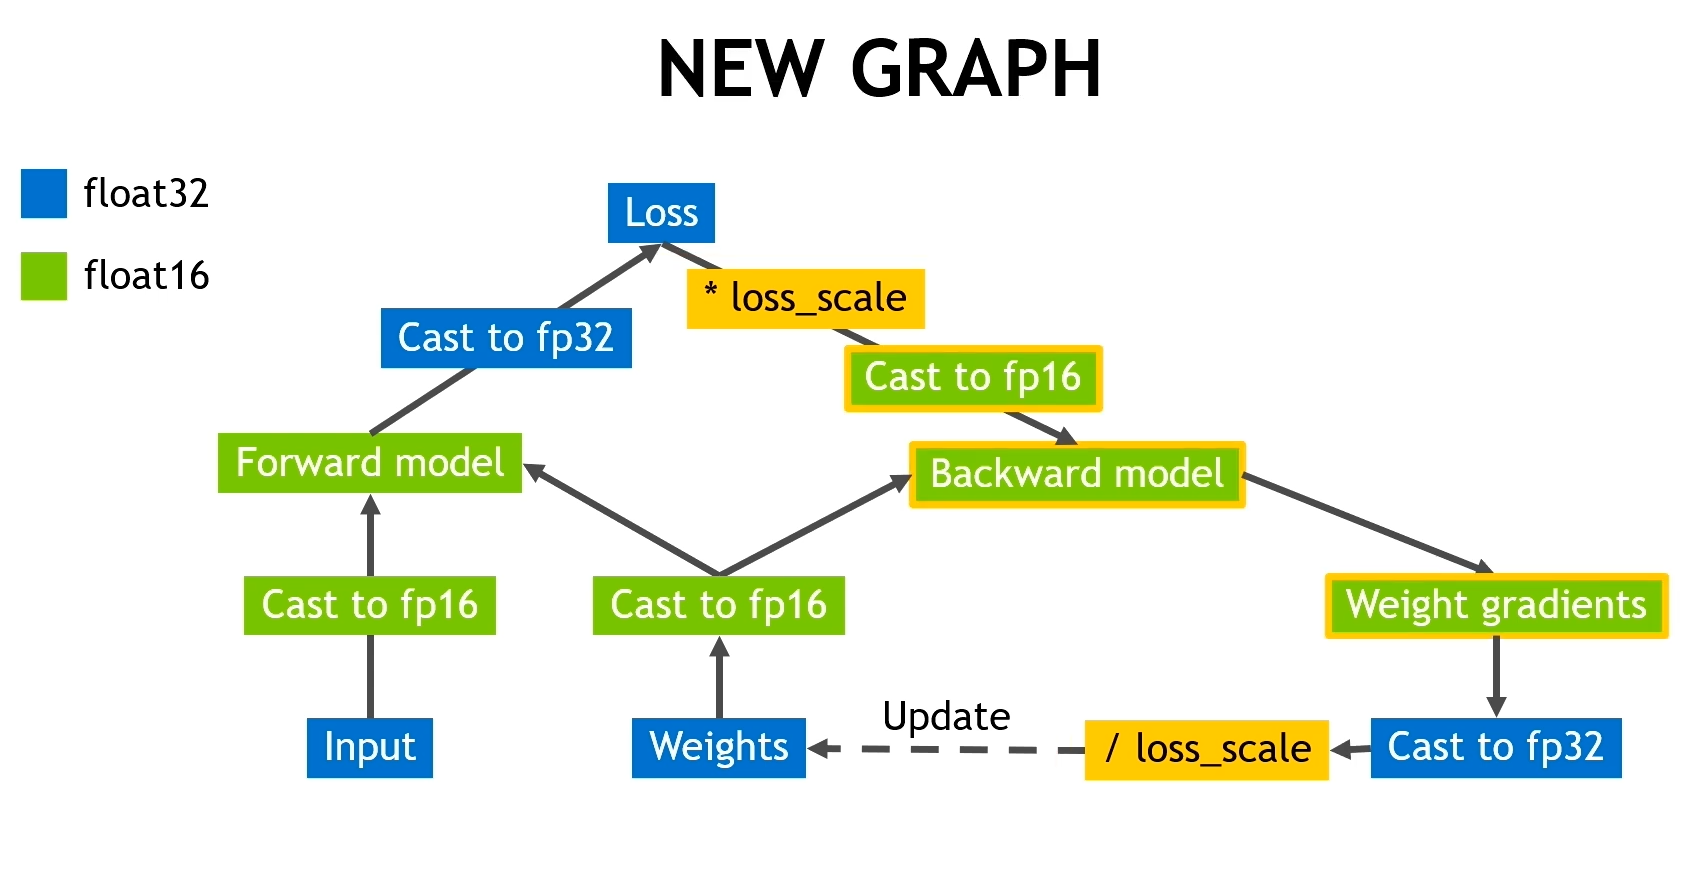

In [3]:
display.Image("png/tf2.png", retina=True)

In [5]:
# Helper functions
# fp32 Master weights
def float32_variable_storage_getter(getter, name, shape=None, dtype=None,
                                   initializer=None, regularizer=None,
                                   trainable=True,
                                   *args, **kwargs):
    '''Custom variable getter that forces trainable variables to be stored in
    float32 precision and the casts them to the training precision.'''
    storage_dtype = tf.float32 if trainable else dtype
    variable = getter(name, shape, dtype=storage_dtype,
                     initializer = initializer, regularizer=regularizer,
                     trainable=trainable,
                     *args, **kwargs)
    if trainable and dtype != tf.float32:
        variable = tf.cast(variable, dtype)
    return variable


In [6]:
def build_training_model(inputs, labels, nlabel):
    
    inputs = tf.cast(inputs, tf.float16)   # <--- fp16
    
    # helper function
    with tf.variable_scope('fp32_vars', custom_getter=float32_variable_storage_getter):
        top_layer = build_forward_model(inputs)
        logits    = tf.layers.dense(top_layer, nlabel, activation=None)
    
    logits    = tf.cast(logits, tf.float32)  # <--- fp32
    
    loss      = tf.losses.sparse_softmax_cross_entropy(logits=logits, labels=labels)
    optimizer = tf.train.MomentumOptimizer(learning_rate=0.01, momentum=0.9)
    
    # Avoid gradient underflow
    loss_scale = 128.0
    gradients, variables = zip(*optimizer.compute_gradients(loss * loss_scale))
    gradients  = [grad / loss_scale for grad in gradients]
    
    gradients, _ = tf.clip_by_global_norm(gradients, 5.0) # clip gradients
    
    train_op  = optimizer.apply_gradients(zip(gradients, variables))
    
    return inputs, labels, loss, train_op
    

In [7]:
st = time.time()
for step in range(20):
    loss_np, _ = sess.run([loss, train_op],
                         {inputs: inputs_np,
                         labels: labels_np}) 
    print("loss=", loss_np)

ed = time.time()
print(f'time: {np.round((ed-st),2)} sec')

# time: 31.86 sec, 22.25 GPU, loss=8.9

2023-07-18 13:30:44.197104: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcublas.so.12
2023-07-18 13:30:44.223505: I tensorflow/stream_executor/platform/default/dso_loader.cc:50] Successfully opened dynamic library libcudnn.so.8


loss= 7.00346
loss= 13.338008
loss= 41.6097
loss= 99.72123
loss= 92.09552
loss= 141.1002
loss= 64.98576
loss= 6.8954787
loss= 6.9284945
loss= 7.2923455
loss= 6.895308
loss= 6.8772297
loss= 7.2943506
loss= 6.9006386
loss= 6.8536725
loss= 7.499727
loss= 7.068901
loss= 7.617703
loss= 9.009368
loss= 8.989472
time: 31.86 sec
